In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
from d2l import torch as d2l

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 计算设备

CPU：torch.device('cpu')

GPU：torch.device(f'cuda:{i}')，torch.device('cuda')==torch.device('cuda:0')

In [2]:
torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

In [3]:
# 查询可用的GPU数量
torch.cuda.device_count()

1

获取GPU

In [4]:
def try_gpu(i=0): #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus(): #@save
    """返回所有可⽤的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

# 张量与GPU

⽆论何时我们要对多个项进⾏操作，它们都必须在同⼀个设备上。

否则框架将不知道在哪⾥存储结果，甚⾄不知道在哪⾥执⾏计算。

In [5]:
# 默认情况下，张量走到CPU上创建
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

## 存储到GPU上

In [6]:
# 创建时直接指定存储设备
X = torch.ones(2, 3, device=try_gpu(0))  # 后面可以填哪个GPU
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

## 复制

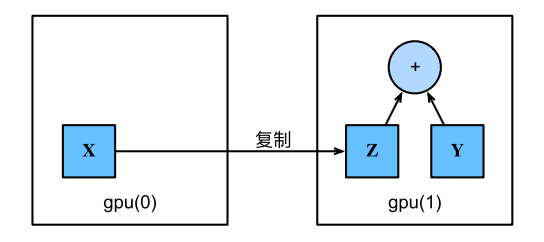

In [10]:
x = torch.tensor([1, 2, 3])
z = x.cuda(0)
print(x)
print(z)

tensor([1, 2, 3])
tensor([1, 2, 3], device='cuda:0')


In [11]:
x + z

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [12]:
x = x.cuda(0)
x + z

tensor([2, 4, 6], device='cuda:0')

# 神经网络与GPU

In [13]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu(0))

In [15]:
net(X)

tensor([[0.2942],
        [0.2942]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
# 模型参数位置
net[0].weight.data.device

device(type='cuda', index=0)

只要所有的数据和参数都在同⼀个设备上，我们就可以有效地学习模型。

In [ ]:
# 1，查看gpu信息
if_cuda = torch.cuda.is_available()
print("if_cuda=",if_cuda)

# GPU 的数量
gpu_count = torch.cuda.device_count()
print("gpu_count=",gpu_count)


# 2，将张量在gpu和cpu间移动
tensor = torch.rand((100,100))
tensor_gpu = tensor.to("cuda:0") # 或者 tensor_gpu = tensor.cuda()
print(tensor_gpu.device)
print(tensor_gpu.is_cuda)

tensor_cpu = tensor_gpu.to("cpu") # 或者 tensor_cpu = tensor_gpu.cpu() 
print(tensor_cpu.device)

# 3，将模型中的全部张量移动到gpu上
net = nn.Linear(2,1)
print(next(net.parameters()).is_cuda)
net.to("cuda:0") # 将模型中的全部参数张量依次到GPU上，注意，无需重新赋值为 net = net.to("cuda:0")
print(next(net.parameters()).is_cuda)
print(next(net.parameters()).device)

# 4，创建支持多个gpu数据并行的模型
linear = nn.Linear(2,1)
print(next(linear.parameters()).device)

model = nn.DataParallel(linear)
print(model.device_ids)
print(next(model.module.parameters()).device) 

#注意保存参数时要指定保存model.module的参数
torch.save(model.module.state_dict(), "./data/model_parameter.pkl") 

linear = nn.Linear(2,1)
linear.load_state_dict(torch.load("./data/model_parameter.pkl")) 

# 5，清空cuda缓存
# 该方在cuda超内存时十分有用
torch.cuda.empty_cache()